### Урок 4

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Импорт необходимых библиотек

In [1]:
import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import seaborn as sns   # Импорт библиотеки Seaborn для визуализации данных
import matplotlib.pyplot as plt # Импортируем библиотеку matplotlib.pyplot для построения графиков

from sklift.viz import plot_qini_curve  # Импорт функции для построения кривой Qini
# Импорт функции для отображения uplift в зависимости от процентилей
from sklift.viz.base import plot_uplift_by_percentile  
from sklift.viz import plot_uplift_curve  # Импорт функции для построения кривой uplift
from sklift.viz import plot_uplift_preds  # Импорт функции для визуализации предсказаний uplift

# Импортируем функцию train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Импорт класса StandardScaler из scikit-learn

from sklift.metrics import uplift_at_k  # Импорт функции для вычисления оценки uplift_at_k
from sklift.models import SoloModel  # Импорт модели SoloModel для оценки uplift
from sklift.models import ClassTransformation  # Импорт модели ClassTransformation для оценки uplift
from sklift.models import TwoModels  # Импорт модели TwoModels для оценки uplift

from catboost import CatBoostClassifier  # Импортируем классификатор CatBoost

from IPython.display import Image  # Импортируем функцию Image для отображения изображений
# Импорт моделей UpliftTreeClassifier и UpliftRandomForestClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier  
# Импорт функций для работы с деревьями uplift
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot  

# Настраиваем формат вывода графиков в виде векторных изображений (SVG)
# %config InlineBackend.figure_format = 'svg'

%matplotlib inline

### 1. Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
# Загрузка данных из CSV-файла в объект DataFrame
df = pd.read_csv('./data/data.csv')

# Вывод первых строк данных для предварительного просмотра
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### 2. Там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
# Список старых имен столбцов
list_to_rename = ['offer', 'conversion']

# Список новых имен столбцов
target_list = ['treatment', 'target']

# Переименование столбцов в объекте DataFrame df
df = df.rename(columns={list_to_rename[0]: target_list[0], list_to_rename[1]: target_list[1]})

# Вывод первых строк обновленных данных для предварительного просмотра
df.head()


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
# Получение уникальных значений из столбца 'treatment' и преобразование их в список
treatment_list = df['treatment'].unique().tolist()

# Извлечение значения 'No Offer' из списка и удаление его
negative_list = treatment_list.pop(treatment_list.index('No Offer'))

# Применение функции-лямбда к столбцу 'treatment', заменяя 'No Offer' на 0, а все остальные значения на 1
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == negative_list else 1)

# Вывод первых строк обновленных данных для предварительного просмотра
df.head()


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


### 3. Cделать разбиение набора данных не тренировочную и тестовую выборки

In [5]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), 
                                                    df['target'], random_state=42, test_size=0.3)

### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [6]:
# Список DataFrame, которые нужно обработать
df_list = [X_train, X_test]

# Инициализация стандартизатора
scaler = StandardScaler()

# Проход по каждому DataFrame в списке
for df_sample in df_list:
    # Создание нового столбца 'disc_bogo' в DataFrame, который представляет собой сумму столбцов 'used_discount' 
    # и 'used_bogo'
    df_sample['disc_bogo'] = df_sample['used_discount'] + df_sample['used_bogo']
    
    # Применение функции-лямбда к столбцу 'disc_bogo', заменяя 1 на 0, и все остальные значения на 1
    df_sample['disc_bogo'] = df_sample['disc_bogo'].apply(lambda x: 0 if x == 1 else 1)
    
# Создание списка convert_float, содержащего имена столбцов с целочисленными значениями, у которых более 
# 2 уникальных значений
convert_float = [col for col in X_train.select_dtypes('int').columns if X_train[col].nunique() > 2]

# Создание списка cat_columns, содержащего имена столбцов с типом 'object' (категориальные столбцы)
cat_columns = X_train.select_dtypes(include=['object']).columns.to_list()


In [7]:
def OHE_featuring(df, cat_columns, convert_float):
    # Преобразование целочисленных столбцов во float
    df[convert_float] = df[convert_float].astype('float')
    
    # Применение one-hot encoding к категориальным столбцам
    df_get_dummies = pd.get_dummies(df[cat_columns], columns=cat_columns).astype(int)
    
    # Объединение обработанных данных
    df = pd.concat([df.drop(columns=cat_columns), df_get_dummies], axis=1)
    
    # Создание столбца 'disc_bogo_treated' на основе условий
    df['disc_bogo_treated'] = df.apply(lambda row: 1 if (row['disc_bogo'] == 1) & (row['treatment'] == 1) else 0, axis=1)
    
    # Создание столбца 'recent_history' путем умножения 'recency' на 'history'
    df['recent_history'] = df['recency'] * df['history']
    
    # Стандартизация всех столбцов с типом float
    float_columns = df.select_dtypes(include='float').columns
    df[float_columns] = scaler.fit_transform(df[float_columns])
    
    return df

# Применение функции OHE_featuring к каждому объекту DataFrame в списке df_list
X_train, X_test = [OHE_featuring(df, cat_columns, convert_float) for df in df_list]


### 5. Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

#### 1. Одна модель с признаком коммуникации (S learner)

In [8]:
# Получение индексов объекта DataFrame X_train
indices_train = X_train.index

# Разделение индексов на обучающий и валидационный наборы
indices_learn, indices_valid = train_test_split(X_train.index, test_size=0.3, random_state=42)


In [9]:
# Создание обучающего набора
train_X = X_train.loc[indices_learn, :].drop(columns='treatment')
train_y = y_train.loc[indices_learn]
treat_train = X_train.loc[indices_learn, 'treatment']

# Создание валидационного набора
X_val = X_train.loc[indices_valid, :].drop(columns='treatment')
y_val = y_train.loc[indices_valid]
treat_val =  X_train.loc[indices_valid, 'treatment']

# Создание полного набора для обучения
X_train_full = X_train.loc[indices_train, :].drop(columns='treatment')
y_train_full = y_train.loc[indices_train]
treat_train_full = X_train.loc[:, 'treatment']

# Инициализация словаря для хранения результатов моделей
models_results = {
    'approach': [],
    'uplift@30%': []
}


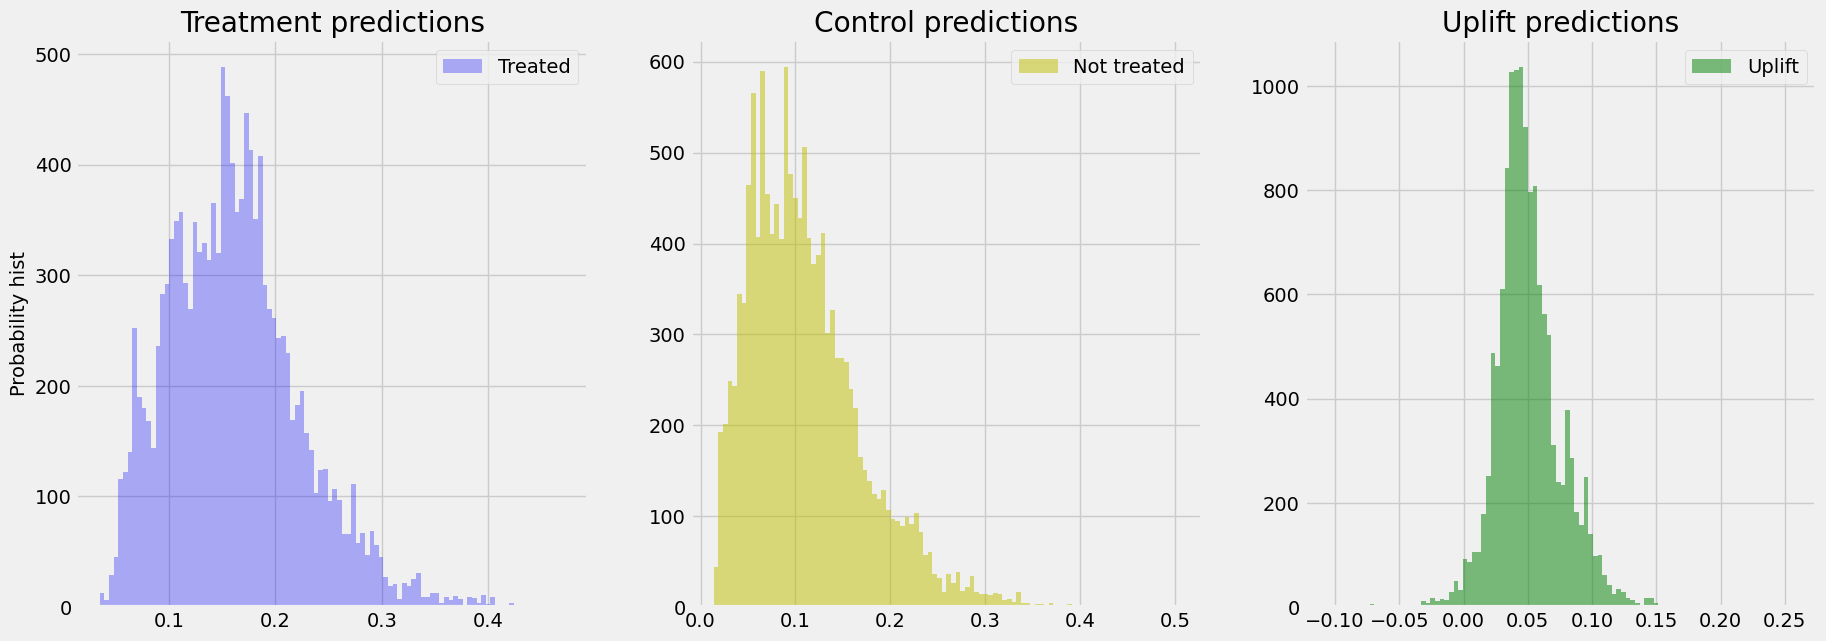

In [10]:
# Создание и обучение модели SoloModel
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(train_X, train_y, treat_train)

# Прогнозирование uplift на валидационном наборе данных
uplift_sm = sm.predict(X_val)

# Вычисление uplift@30%
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

# Добавление результатов в словарь models_results
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получение предсказаний для 'экспериментальных' и контрольных групп
sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

# Визуализация предсказаний uplift
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


In [11]:
# Создание DataFrame с важностью признаков для модели SoloModel
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

# Вывод DataFrame с важностью признаков
sm_fi


,feature_name,feature_score
0,is_referral,18.207168
1,treatment,15.223619
2,history,14.960335
3,recency,14.817696
4,recent_history,7.646075
5,channel_Web,5.539396
6,zip_code_Rural,5.208913
7,disc_bogo,3.702123
8,used_bogo,3.626080
9,disc_bogo_treated,3.270670


#### 2. модель с трансформацией таргета 

In [12]:
# Создание и обучение модели ClassTransformation
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(train_X, train_y, treat_train)

# Прогнозирование uplift на валидационном наборе данных
uplift_ct = ct.predict(X_val)

# Вычисление uplift@30%
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

# Добавление результатов в словарь models_results
models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)


In [13]:
# Создание DataFrame на основе словаря models_results
results_df = pd.DataFrame(models_results)

# Вывод DataFrame с результатами
results_df


,approach,uplift@30%
0,SoloModel,0.078121
1,ClassTransformation,0.031457


In [14]:
# Создание DataFrame с важностью признаков для модели ClassTransformation
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

# Вывод DataFrame с важностью признаков
ct_fi


,feature_name,feature_score
0,disc_bogo_treated,36.697549
1,disc_bogo,29.100541
2,recent_history,7.031880
3,history,5.963113
4,recency,5.373672
5,is_referral,3.471431
6,zip_code_Rural,3.112367
7,zip_code_Urban,2.261159
8,channel_Phone,1.918871
9,channel_Web,1.896465


#### 3. Вариант с двумя независимыми моделями

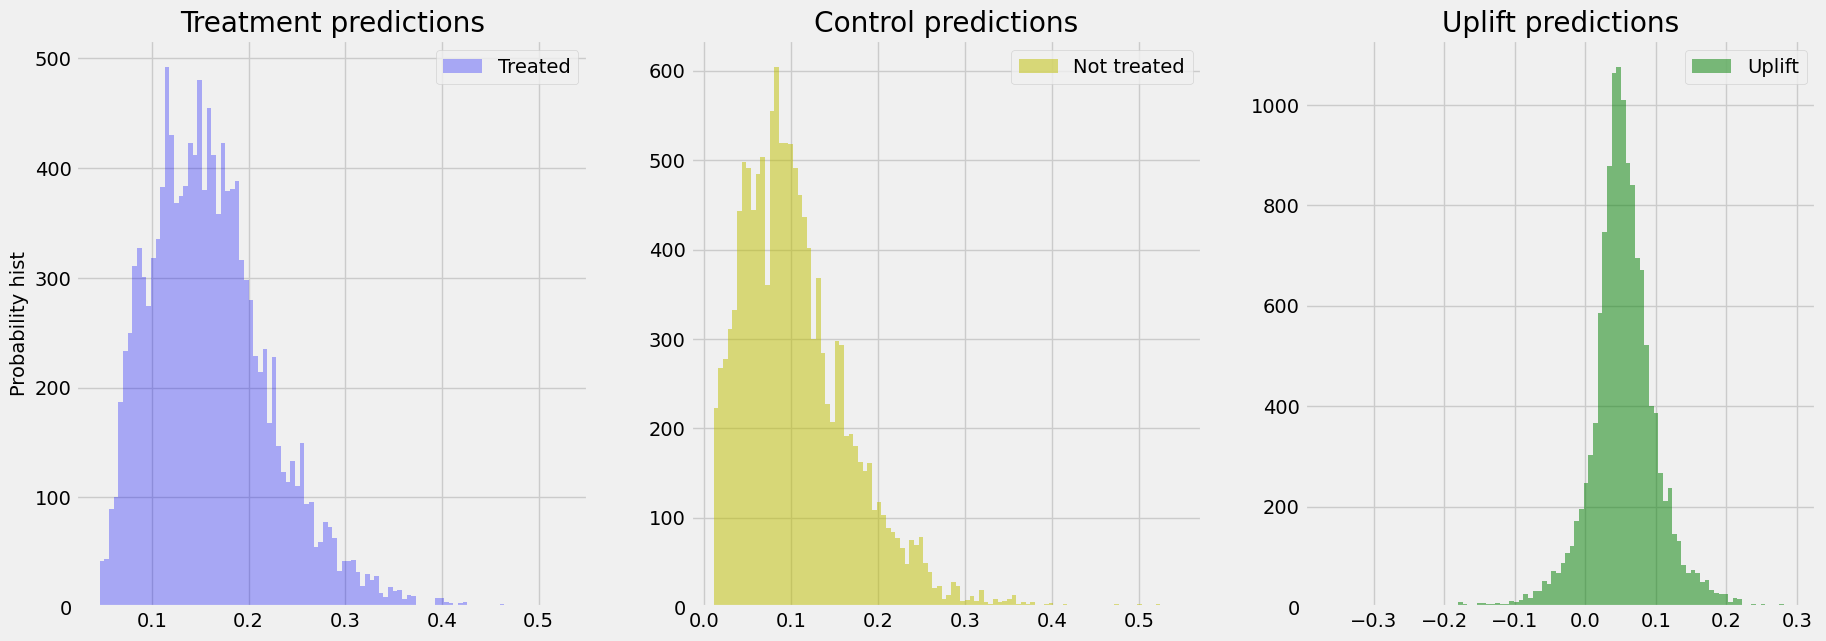

In [15]:
# Создание и обучение модели TwoModels с использованием двух отдельных моделей
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(train_X, train_y, treat_train)

# Прогнозирование uplift на валидационном наборе данных
uplift_tm = tm.predict(X_val)

# Вычисление uplift@30%
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

# Добавление результатов в словарь models_results
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

# Визуализация предсказаний uplift
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);


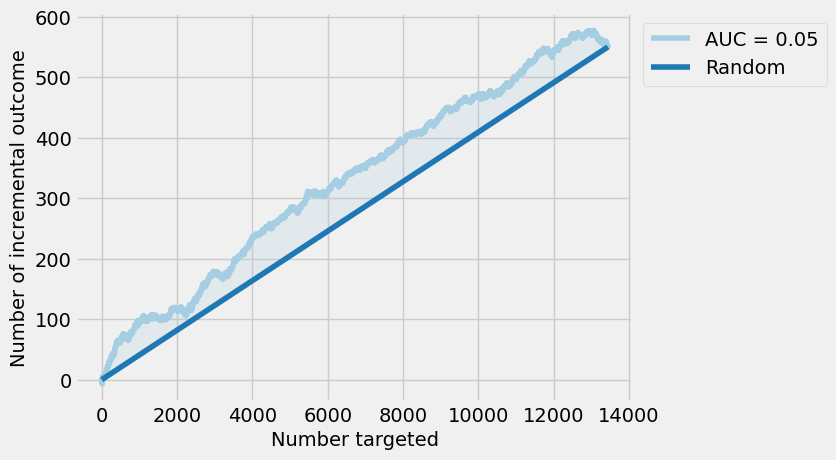

In [16]:
# Построение кривой Qini с использованием оценок uplift
plot_qini_curve(y_true=y_val, uplift=uplift_tm, treatment=treat_val, perfect=False)


In [17]:
# Создание DataFrame на основе словаря models_results
results_df = pd.DataFrame(models_results)

# Вывод DataFrame с результатами
results_df


,approach,uplift@30%
0,SoloModel,0.078121
1,ClassTransformation,0.031457
2,TwoModels,0.086694


In [18]:
# Создание DataFrame с важностью признаков для модели TwoModels (для третированных групп)
tm_fi = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score': tm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

# Вывод DataFrame с важностью признаков
tm_fi


,feature_name,feature_score
0,history,19.895198
1,is_referral,17.188459
2,recency,15.588503
3,recent_history,11.243538
4,disc_bogo_treated,10.333184
5,zip_code_Rural,7.052753
6,channel_Web,6.179865
7,channel_Phone,3.405419
8,used_bogo,3.267259
9,used_discount,2.825082


#### 6. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [19]:
# Список с именами методов и соответствующими прогнозами uplift
models = [
    ['SoloModel', 'ClassTransformation', 'TwoModels'], 
    [uplift_sm, uplift_ct, uplift_tm]
]

# Словарь для хранения оценок uplift
models_scores = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

count = 0

# Перебор разных уровней uplift (10%, 20%, 30%)
for i in range(10, 40, 10):
    for approach, mod in zip(models[0], models[1]):
        # Вычисление оценки uplift для данного метода и уровня uplift
        approach_score = uplift_at_k(y_true=y_val, uplift=mod, treatment=treat_val, strategy='by_group', k=i/100)
        models_scores[f'uplift@{i}%'].append(approach_score)
    models_scores['approach'].append(models[0][count])
    count += 1



In [20]:
# Создание DataFrame на основе словаря models_scores
models_scores_df = pd.DataFrame(models_scores)

# Вывод DataFrame с оценками uplift
models_scores_df


,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.099848,0.082424,0.078121
1,ClassTransformation,0.000967,0.011341,0.031457
2,TwoModels,0.113475,0.072506,0.086694


#### 7. Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

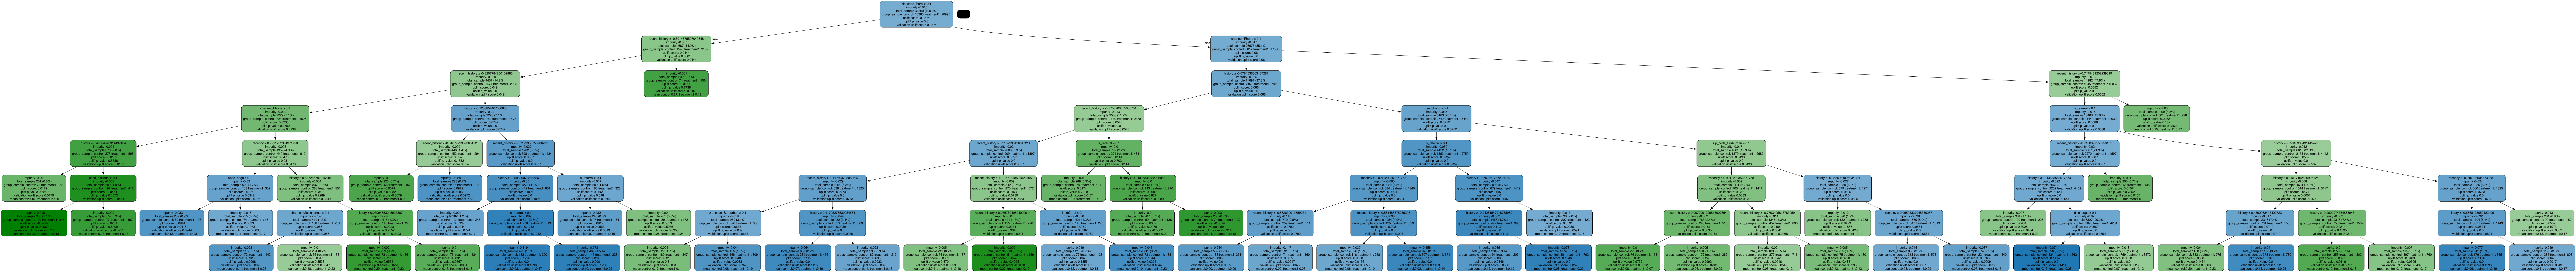

In [21]:
# Определение списка признаков
features = [col for col in train_X]

# Создание и обучение модели UpliftTreeClassifier
utc = UpliftTreeClassifier(
    max_depth=8,  # Максимальная глубина дерева
    min_samples_leaf=200,  # Минимальное количество объектов в листе дерева
    min_samples_treatment=50,  # Минимальное количество объектов в листе для третированных групп
    n_reg=100,  # Количество регрессионных моделей для оценки uplift
    evaluationFunction='KL',  # Функция оценки качества модели
    control_name='control'  # Название контрольной группы
)
utc.fit(
    train_X.values,
    treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
    y=train_y
)

# Прогнозирование uplift на валидационном наборе данных
utc_uplift = utc.predict(X_val)

# Визуализация дерева принятия решений
graph = uplift_tree_plot(utc.fitted_uplift_tree, features)
Image(graph.create_png())


In [22]:
# Создание списка utc_uplift_list из прогнозов uplift
utc_uplift_list = [utc_uplift[i][0] for i in range(len(utc_uplift))]

# Вычисление оценки uplift@30%
utc_score = uplift_at_k(y_true=y_val, uplift=utc_uplift_list, treatment=treat_val, strategy='by_group', k=0.3)

# Добавление результатов в словарь models_results
models_results['approach'].append('UpliftTreeClassifier')
models_results['uplift@30%'].append(utc_score)


In [23]:
# Создание DataFrame на основе словаря models_results
results_df = pd.DataFrame(models_results)

# Вывод DataFrame с результатами
results_df

,approach,uplift@30%
0,SoloModel,0.078121
1,ClassTransformation,0.031457
2,TwoModels,0.086694
3,UpliftTreeClassifier,0.062551


#### 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
- 1) сделать прогноз и получить uplift для тестовой выборки 
- 2) отсортировать тестовую выборку по uplift по убыванию 
- 3) разбить на децили (pandas qcut вам в помощь) 
- 4) для каждого дециля посчитать среднюю conversion


In [24]:
# 1. сделать прогноз и получить uplift для тестовой выборки

s_learner_uplift = sm.predict(X_test)

In [25]:
# 2. отсортировать тестовую выборку по uplift по убыванию

df_uplift = pd.concat([X_test.reset_index(drop=True), pd.Series(s_learner_uplift, name='s_learner_uplift'), \
                       pd.Series(y_test, name='conversion').reset_index(drop=True)], \
                      axis=1).sort_values(by='s_learner_uplift', ascending=False)

In [26]:
# 3. разбить на децили (pandas qcut вам в помощь)

deciles = pd.qcut(df_uplift['s_learner_uplift'], q=10, labels=False)

df_uplift['decile'] = deciles

In [27]:
# 4. для каждого дециля посчитать среднюю conversion

mean_uplift = df_uplift.groupby('decile')\
['s_learner_uplift'].agg(mean_uplift='mean').sort_values(by='decile', ascending=False)
mean_uplift

,mean_uplift
decile,
9,0.100922
8,0.075840
7,0.063143
6,0.055421
5,0.049277
4,0.044295
3,0.039606
2,0.034773
1,0.027521


#### 9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [28]:
# Создание списка features, который содержит названия признаков
features = [col for col in train_X]

# Создание и настройка модели UpliftRandomForestClassifier
rfc = UpliftRandomForestClassifier(
    n_estimators=100,  # Количество деревьев в случайном лесу
    max_depth=8,  # Максимальная глубина каждого дерева
    min_samples_leaf=200,  # Минимальное количество объектов в листе дерева
    min_samples_treatment=50,  # Минимальное количество объектов в листе для третированных групп
    n_reg=100,  # Количество регрессионных моделей для оценки uplift
    evaluationFunction='KL',  # Функция оценки качества модели
    control_name='control'  # Название контрольной группы
)

# Обучение модели на обучающем наборе данных
rfc.fit(train_X.values, treat_train.map({1:'treatment', 0:'control'}).values, train_y.values)

# Прогнозирование uplift на валидационном наборе данных
rfc_uplift = rfc.predict(X_val)


In [29]:
# Преобразование двумерного массива rfc_uplift в одномерный массив
rfc_uplift = rfc_uplift.flatten()

# Вычисление оценки uplift@30%
rfc_score = uplift_at_k(y_true=y_val, uplift=rfc_uplift, treatment=treat_val, strategy='by_group', k=0.3)

# Добавление результатов в словарь models_results
models_results['approach'].append('URFClassifier')
models_results['uplift@30%'].append(rfc_score)


In [30]:
# Создание DataFrame на основе словаря models_results
results_df = pd.DataFrame(models_results)

# Вывод DataFrame с результатами
results_df

,approach,uplift@30%
0,SoloModel,0.078121
1,ClassTransformation,0.031457
2,TwoModels,0.086694
3,UpliftTreeClassifier,0.062551
4,URFClassifier,0.060143


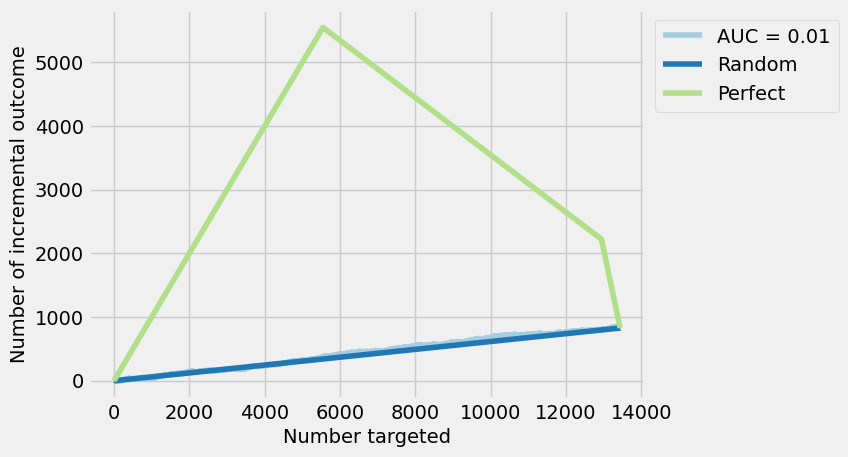

In [31]:
# Построение кривой uplift с использованием прогнозов uplift от модели UpliftRandomForestClassifier
plot_uplift_curve(y_true=y_val, uplift=rfc_uplift, treatment=treat_val, perfect=True);


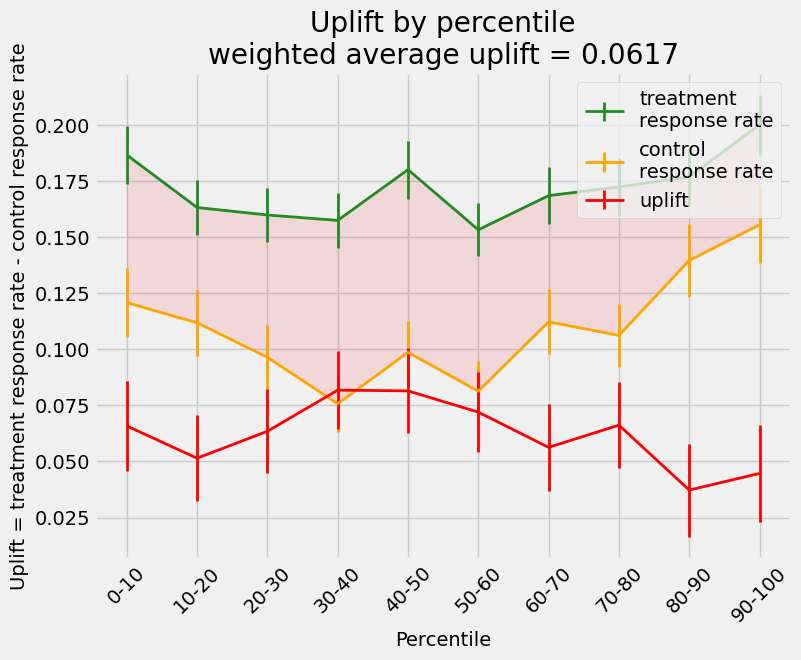

In [35]:
# Построение графика uplift в зависимости от процентиля с использованием прогнозов uplift от модели UpliftRandomForestClassifier
plot_uplift_by_percentile(
    y_true=y_val, 
    uplift=rfc_uplift, 
    treatment=treat_val, 
    strategy='overall',  # Метод оценки uplift для всего набора данных
    kind='line',  # Тип графика (линейный)
    bins=10,  # Количество бинов (процентилей)
    string_percentiles=True  # Отображать процентили как строки
);


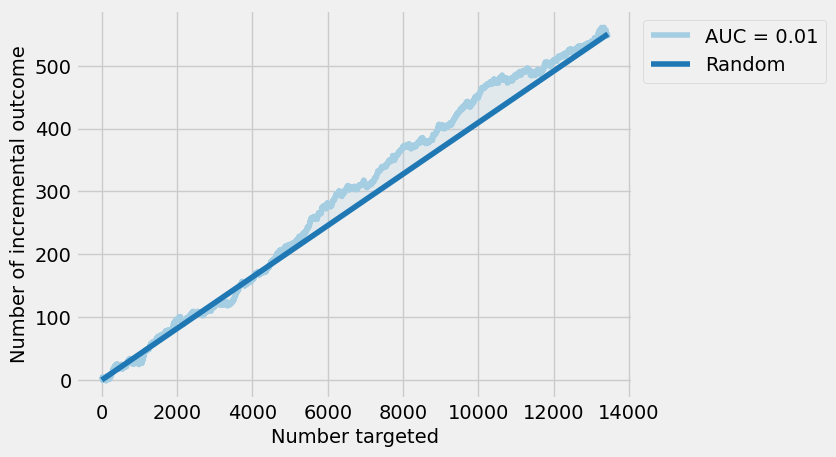

In [34]:
# Построение кривой Qini с использованием прогнозов uplift от модели UpliftRandomForestClassifier
plot_qini_curve(y_true=y_val, uplift=rfc_uplift, treatment=treat_val, perfect=False);
